In [1]:
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 1376
algorithm_globals.random_seed = seed

# Use ad hoc data set for training and test data
feature_dim = 2  # dimension of each data point
training_size = 20
test_size = 10

# training features, training labels, test features, test labels as np.ndarray,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=training_size, test_size=test_size, n=feature_dim, gap=0.3
)

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")
ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
)
vqc.fit(training_features, training_labels)

score = vqc.score(test_features, test_labels)
print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.95


# 1. Introduction
## 1.1. Quantum vs. Classical Neural Networks
Classical neural networks are algorithmic models inspired by the human brain that can be trained to recognize patterns in data and learn to solve complex problems. They are based on a series of interconnected nodes, or neurons, organized in a layered structure, with parameters that can be learned by applying machine or deep learning training strategies.

The motivation behind quantum machine learning (QML) is to integrate notions from quantum computing and classical machine learning to open the way for new and improved learning schemes. QNNs apply this generic principle by combining classical neural networks and parametrized quantum circuits. Because they lie at an intersection between two fields, QNNs can be viewed from two perspectives:

From a machine learning perspective, QNNs are, once again, algorithmic models that can be trained to find hidden patterns in data in a similar manner to their classical counterparts. These models can load classical data (inputs) into a quantum state, and later process it with quantum gates parametrized by trainable weights. Figure 1 shows a generic QNN example including the data loading and processing steps. The output from measuring this state can then be plugged into a loss function to train the weights through backpropagation.

From a quantum computing perspective, QNNs are quantum algorithms based on parametrized quantum circuits that can be trained in a variational manner using classical optimizers. These circuits contain a feature map (with input parameters) and an ansatz (with trainable weights), as seen in Figure 1.

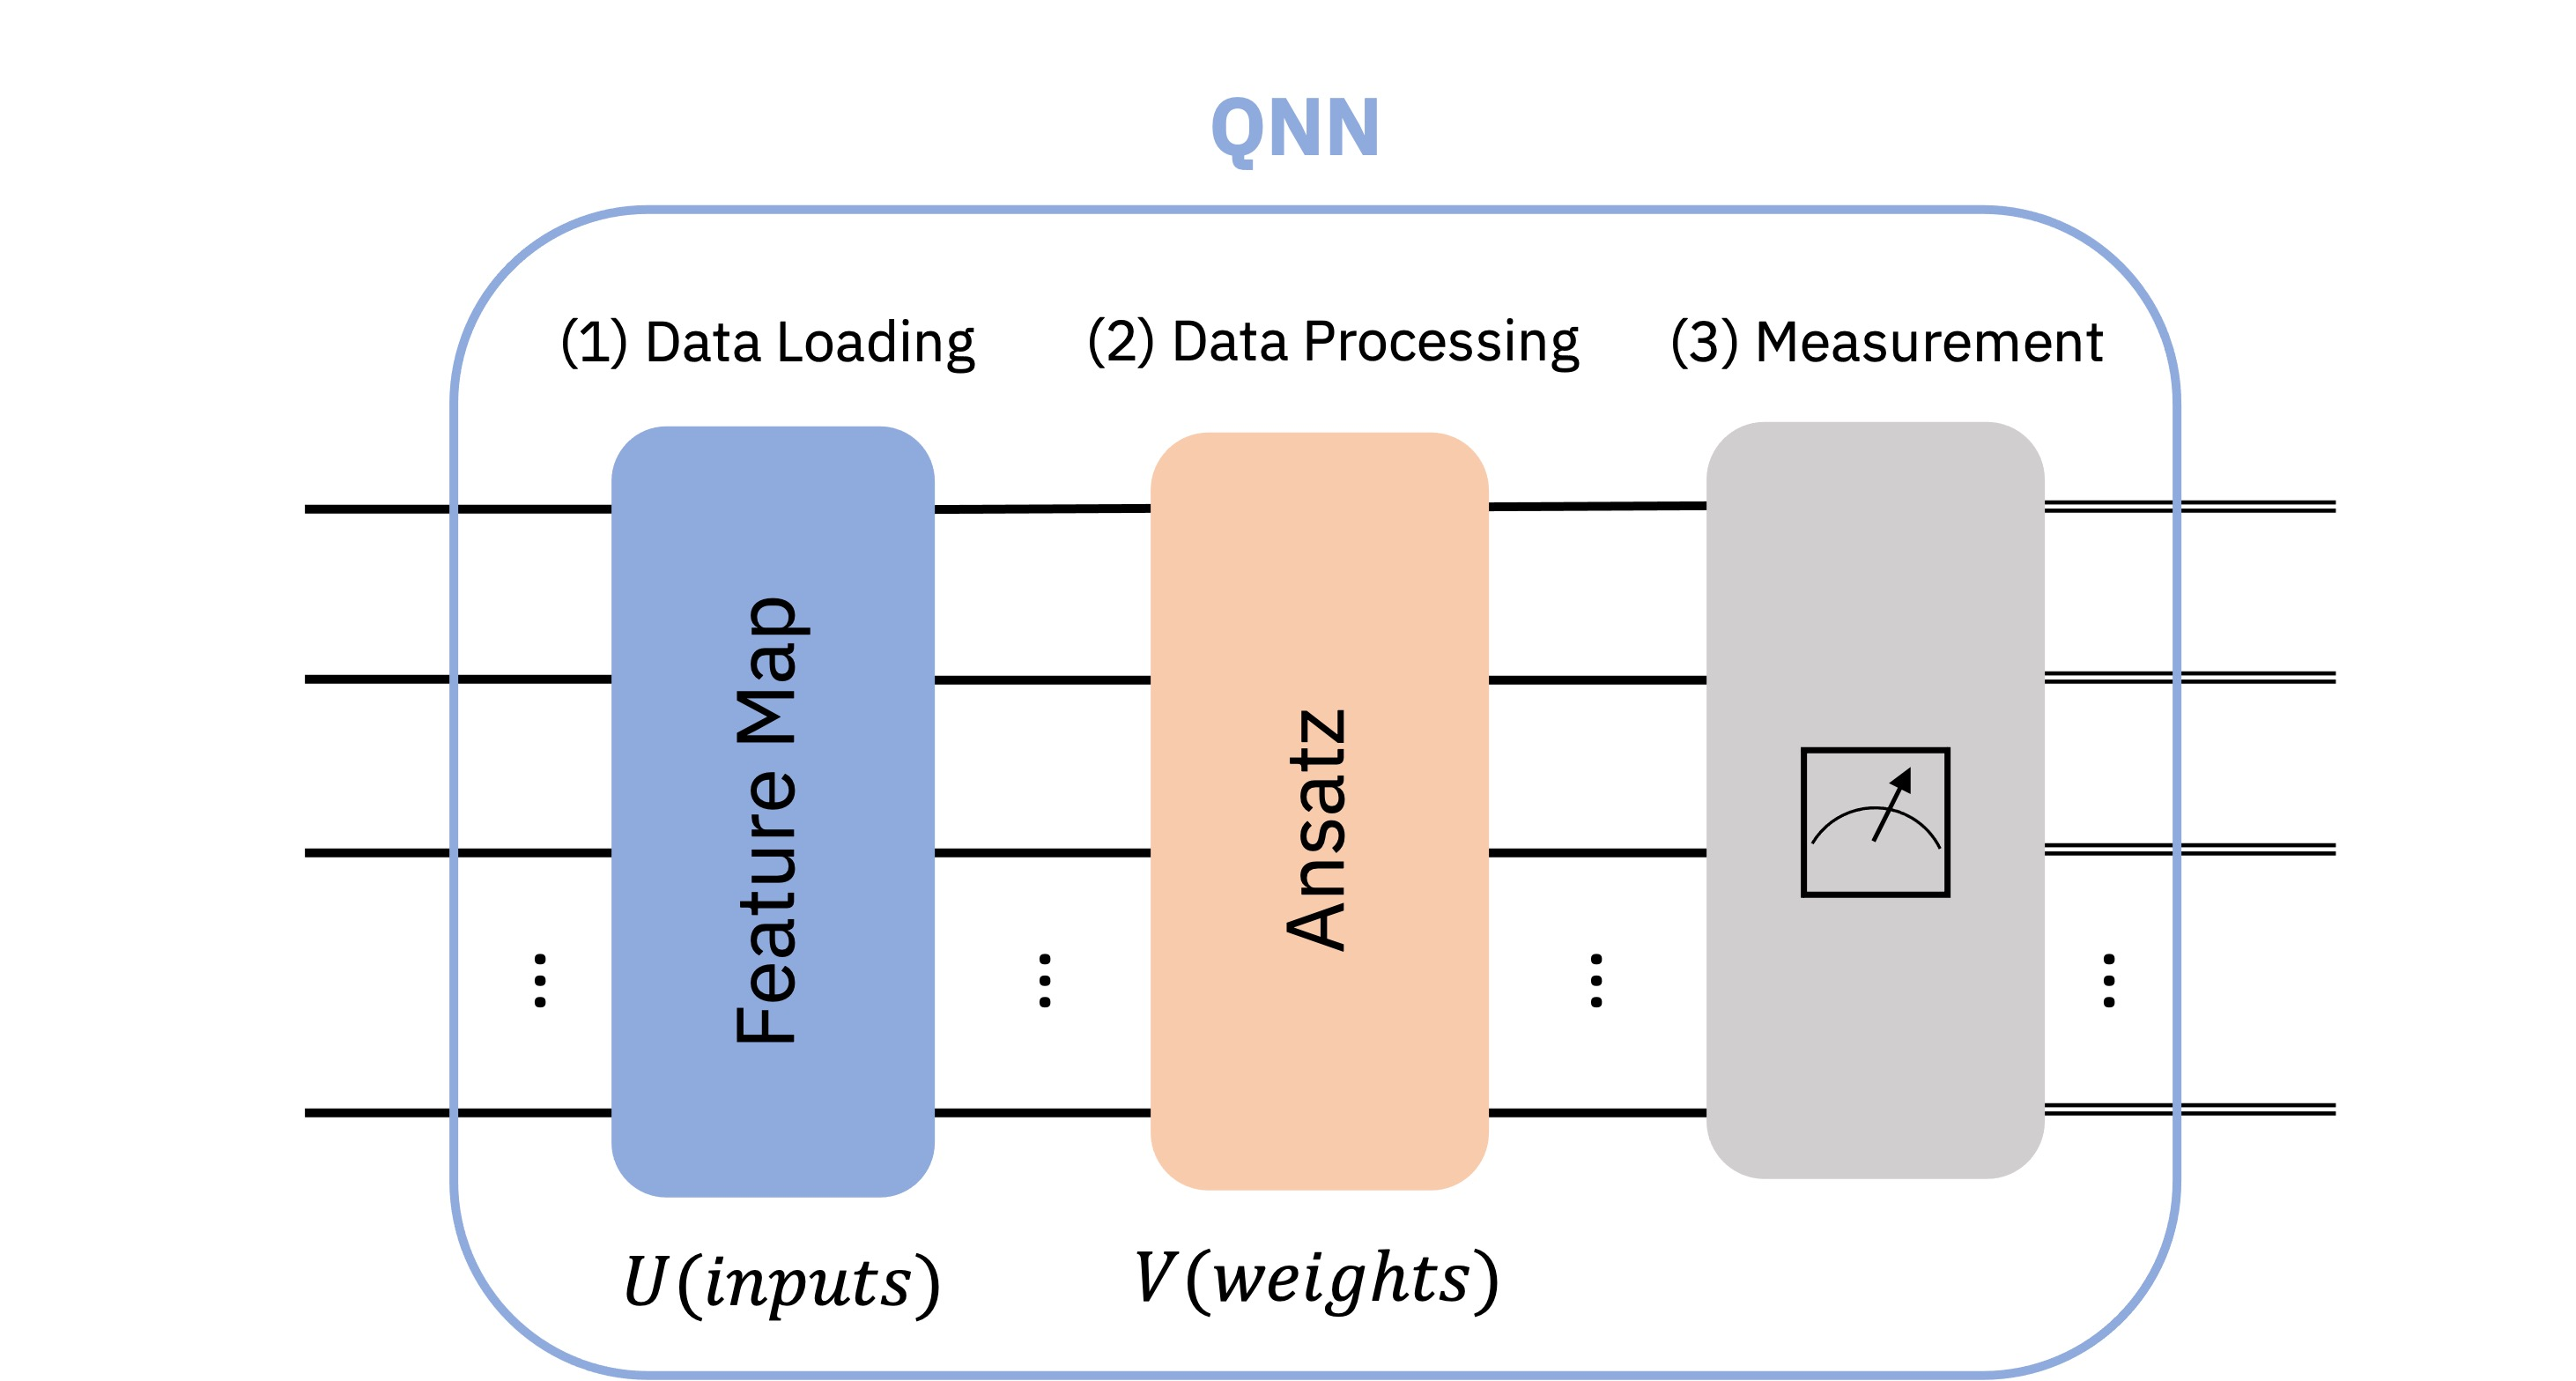

Figure 1. Generic quantum neural network (QNN) structure.

As you can see, these two perspectives are complementary, and do not necessarily rely on strict definitions of concepts such as “quantum neuron” or what constitutes a QNN’s “layer”.

## 1.2. Implementation in qiskit-machine-learning
The QNNs in qiskit-machine-learning are meant as application-agnostic computational units that can be used for different use cases, and their setup will depend on the application they are needed for. The module contains an interface for the QNNs and two specific implementations:

- **NeuralNetwork**: The interface for neural networks. This is an abstract class all QNNs inherit from.

- **EstimatorQNN**: A network based on the evaluation of quantum mechanical observables.

- **SamplerQNN**: A network based on the samples resulting from measuring a quantum circuit.

These implementations are based on the qiskit primitives. The primitives are the entry point to run QNNs on either a simulator or real quantum hardware. Each implementation, EstimatorQNN and SamplerQNN, takes in an optional instance of its corresponding primitive, which can be any subclass of BaseEstimator and BaseSampler, respectively.

The qiskit.primitives module provides a reference implementation for the Sampler and Estimator classes to run statevector simulations. By default, if no instance is passed to a QNN class, an instance of the corresponding reference primitive (Sampler or Estimator) is created automatically by the network. For more information about primitives please refer to the primitives documentation.

The NeuralNetwork class is the interface for all QNNs available in qiskit-machine-learning. It exposes a forward and a backward pass that take data samples and trainable weights as input.

It’s important to note that NeuralNetworks are “stateless”. They do not contain any training capabilities (these are pushed to the actual algorithms or applications: classifiers, regressors, etc), nor do they store the values for trainable weights.

Let’s now look into specific examples for the two NeuralNetwork implementations. But first, let’s set the algorithmic seed to ensure that the results don’t change between runs.

In [24]:
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 42

# 2. How to Instantiate QNNs
## 2.1. EstimatorQNN
The EstimatorQNN takes in a parametrized quantum circuit as input, as well as an optional quantum mechanical observable, and outputs expectation value computations for the forward pass. The EstimatorQNN also accepts lists of observables to construct more complex QNNs.

Let’s see an EstimatorQNN in action with a simple example. We start by constructing the parametrized circuit. This quantum circuit has two parameters, one represents a QNN input and the other represents a trainable weight:

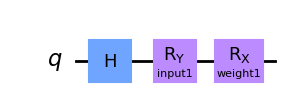

In [2]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl", style="clifford")

We can now create an observable to define the expectation value computation. If not set, then the EstimatorQNN will automatically create the default observable 
. Here, 
 is the number of qubits of the quantum circuit.

In this example, we will change things up and use the 
 observable:

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

Together with the quantum circuit defined above, and the observable we have created, the EstimatorQNN constructor takes in the following keyword arguments:

- estimator: optional primitive instance

- pass_manager: optional pass_manager instance for primitives that require transpilation

- input_params: list of quantum circuit parameters that should be treated as “network inputs”

- weight_params: list of quantum circuit parameters that should be treated as “network weights”

In this example, we previously decided that the first parameter of params1 should be the input, while the second should be the weight. As we are performing a local statevector simulation, we will set the estimator parameter from qiskit.primitives.StatevectorEstimator. If we needed to access cloud resources or Aer simulators, we would have to define the respective Estimator instances and pass them to the EstimatorQNN. If transpilation is required an estimator such as qiskit_ibm_runtime.EstimatorV2, it is required to pass a pass_manager to the EstimatorQNN. In such case, please do not forget that observables might require new layout according to the target.

In [4]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()
estimator_qnn = EstimatorQNN(
    circuit=qc1,
    observables=observable1,
    input_params=[params1[0]],
    weight_params=[params1[1]],
    estimator=estimator,
)
estimator_qnn

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


We’ll see how to use the QNN in the following sections, but before that, let’s check out the SamplerQNN class.

## 2.2. SamplerQNN
The SamplerQNN is instantiated in a similar way to the EstimatorQNN, but because it directly consumes samples from measuring the quantum circuit, it does not require a custom observable.

These output samples are interpreted by default as the probabilities of measuring the integer index corresponding to a bitstring. However, the SamplerQNN also allows us to specify an interpret function to post-process the samples. This function should be defined so that it takes a measured integer (from a bitstring) and maps it to a new value, i.e. non-negative integer.

(!) It’s important to note that if a custom interpret function is defined, the output_shape cannot be inferred by the network, and needs to be provided explicitly.

(!) It’s also important to keep in mind that if no interpret function is used, the dimension of the probability vector will scale exponentially with the number of qubits. With a custom interpret function, this scaling can change. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, the result will be a probability vector of length 2 independently of the number of qubits.

Let’s create a different quantum circuit for the SamplerQNN. In this case, we will have two input parameters and four trainable weights that parametrize a two-local circuit.

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


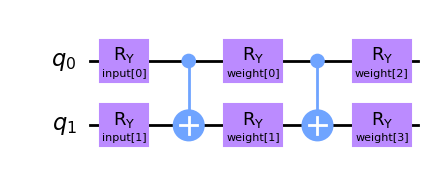

In [5]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw("mpl", style="clifford")

Similarly to the EstimatorQNN, we must specify inputs and weights when instantiating the SamplerQNN. In this case, the keyword arguments will be:

- sampler: optional primitive instance

- pass_manager: optional pass_manager instance for primitives that require transpilation.

- input_params: list of quantum circuit parameters that should be treated as “network inputs”

- weight_params: list of quantum circuit parameters that should be treated as “network weights”

Please note that, once again, we are setting the StatevectorSampler instance from qiskit.primitives to the QNN and relying on statevector.

In [ ]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2, sampler=sampler)
sampler_qnn

# 3. How to Run a Forward Pass
## 3.1. Set-Up
In a real setting, the inputs would be defined by the dataset, and the weights would be defined by the training algorithm or as part of a pre-trained model. However, for the sake of this tutorial, we will specify random sets of input and weights of the right dimension:

### 3.1.1. EstimatorQNN Example

In [29]:
estimator_qnn_input = algorithm_globals.random.random(estimator_qnn.num_inputs)
estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)

In [ ]:
print(
    f"Number of input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {estimator_qnn_input}"
)
print(
    f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {estimator_qnn_weights}"
)

### 3.1.2. SamplerQNN Example

In [10]:
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

In [ ]:
print(
    f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}"
)
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}"
)

Once we have the inputs and the weights, let’s see the results for batched and non-batched passes.

## 3.2. Non-batched Forward Pass
### 3.2.1. EstimatorQNN Example
For the EstimatorQNN, the expected output shape for the forward pass is (1, num_qubits * num_observables) where 1 in our case is the number of samples:

In [ ]:
estimator_qnn_forward = estimator_qnn.forward(estimator_qnn_input, estimator_qnn_weights)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward}. \nShape: {estimator_qnn_forward.shape}"
)

### 3.2.2. SamplerQNN Example
For the SamplerQNN (without a custom interpret function), the expected output shape for the forward pass is (1, 2**num_qubits). With a custom interpret function, the output shape will be (1, output_shape), where 1 in our case is the number of samples:

In [ ]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}"
)

## 3.3. Batched Forward Pass
### 3.3.1. EstimatorQNN Example
For the EstimatorQNN, the expected output shape for the forward pass is (batch_size, num_qubits * num_observables):

In [ ]:
estimator_qnn_forward_batched = estimator_qnn.forward(
    [estimator_qnn_input, estimator_qnn_input], estimator_qnn_weights
)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward_batched}.  \nShape: {estimator_qnn_forward_batched.shape}"
)

### 3.3.2. SamplerQNN Example
For the SamplerQNN (without custom interpret function), the expected output shape for the forward pass is (batch_size, 2**num_qubits). With a custom interpret function, the output shape will be (batch_size, output_shape).

In [ ]:
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward_batched}.  \nShape: {sampler_qnn_forward_batched.shape}"
)

# 4. How to Run a Backward Pass
Let’s take advantage of the inputs and weights defined above to show how the backward pass works. This pass returns a tuple (input_gradients, weight_gradients). By default, the backward pass will only calculate gradients with respect to the weight parameters.

If you want to enable gradients with respect to the input parameters, you should set the following flag during the QNN instantiation:

qnn = ...QNN(..., input_gradients=True)
Please remember that input gradients are required for the use of TorchConnector for PyTorch integration.

## 4.1. Backward Pass without Input Gradients
### 4.1.1. EstimatorQNN Example
For the EstimatorQNN, the expected output shape for the weight gradients is (batch_size, num_qubits * num_observables, num_weights):

In [ ]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad}"
)
print(
    f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

## 4.2. Backward Pass with Input Gradients
Let’s enable the input_gradients to show what the expected output sizes are for this option.

In [17]:
estimator_qnn.input_gradients = True
sampler_qnn.input_gradients = True

### 4.2.1. EstimatorQNN Example
For the EstimatorQNN, the expected output shape for the input gradients is (batch_size, num_qubits * num_observables, num_inputs):

In [ ]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

### 4.2.2. SamplerQNN Example
For the SamplerQNN (without custom interpret function), the expected output shape for the input gradients is (batch_size, 2**num_qubits, num_inputs). With a custom interpret function, the output shape will be (batch_size, output_shape, num_inputs).

In [ ]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad.shape}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

# 5. Advanced Functionality
## 5.1. EstimatorQNN with Multiple Observables
The EstimatorQNN allows to pass lists of observables for more complex QNN architectures. For example (note the change in output shape):

In [ ]:
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

estimator_qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
    estimator=estimator,
)

In [ ]:
estimator_qnn_forward2 = estimator_qnn2.forward(estimator_qnn_input, estimator_qnn_weights)
estimator_qnn_input_grad2, estimator_qnn_weight_grad2 = estimator_qnn2.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(f"Forward output for EstimatorQNN1: {estimator_qnn_forward.shape}")
print(f"Forward output for EstimatorQNN2: {estimator_qnn_forward2.shape}")
print(f"Backward output for EstimatorQNN1: {estimator_qnn_weight_grad.shape}")
print(f"Backward output for EstimatorQNN2: {estimator_qnn_weight_grad2.shape}")

## 5.2. SamplerQNN with custom interpret
One common interpret method for SamplerQNN is the parity function, which allows it to perform binary classification. As explained in the instantiation section, using interpret functions will modify the output shape of the forward and backward passes. In the case of the parity interpret function, output_shape is fixed to 2. Therefore, the expected forward and weight gradient shapes are (batch_size, 2) and (batch_size, 2, num_weights), respectively:

In [ ]:
parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # parity = 0, 1

sampler_qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=inputs2,
    weight_params=weights2,
    interpret=parity,
    output_shape=output_shape,
    sampler=sampler,
)

In [ ]:
sampler_qnn_forward2 = sampler_qnn2.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad2, sampler_qnn_weight_grad2 = sampler_qnn2.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Forward output for SamplerQNN1: {sampler_qnn_forward.shape}")
print(f"Forward output for SamplerQNN2: {sampler_qnn_forward2.shape}")
print(f"Backward output for SamplerQNN1: {sampler_qnn_weight_grad.shape}")
print(f"Backward output for SamplerQNN2: {sampler_qnn_weight_grad2.shape}")